In [1]:
import json

# Replace 'your_file.txt' with the actual file name
file_path = 'data/davis/proteins.txt'

with open(file_path, 'r') as file:
    data = json.loads(file.read())  # Load the file as a dictionary

num_proteins = len(data)  # Count the number of keys (protein names)
unique_proteins = len(set(data.values()))  # Count unique protein sequences

print(f"Number of proteins: {num_proteins}")
print(f"Number of unique proteins: {unique_proteins}")


import pandas as pd

# Replace 'your_file.csv' with the actual file name
file_path = 'data/davis_original.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Count unique target sequences
num_unique_proteins = df['target_sequence'].nunique()

print(f"Number of unique proteins: {num_unique_proteins}")



FileNotFoundError: [Errno 2] No such file or directory: 'data/davis/proteins.txt'

Setting up the non csv data files for davis data random split

In [5]:
import pandas as pd
import numpy as np
import json
import pickle
import os

# File paths
train_file = '../data/davis/davis_train.csv'
test_file = '../data/davis/davis_test.csv'

# Load train and test datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Combine both datasets
davis_df = pd.concat([train_df, test_df], ignore_index=True)

# Create dictionaries to store ligands, proteins, and affinities
ligands = {}  # Drug_ID -> SMILES
proteins = {}  # Target_ID -> Sequence
y_affinities = {}  # (Drug_ID, Target_ID) -> Affinity

# Process the dataset
for _, row in davis_df.iterrows():
    drug_id = row['Drug_ID']
    smiles = row['Drug']
    target_id = row['Target_ID']
    sequence = row['Target']
    affinity = row['Y']
    
    # Store unique ligands
    if drug_id not in ligands:
        ligands[drug_id] = smiles
    
    # Store unique proteins
    if target_id not in proteins:
        proteins[target_id] = sequence
    
    # Store affinity values
    y_affinities[(drug_id, target_id)] = affinity

# Create a sorted list of unique drug_ids and target_ids
drug_ids = sorted(ligands.keys())
target_ids = sorted(proteins.keys())

# Initialize a 2D NumPy array with a default affinity value of 5.0
affinity_matrix = np.full((len(drug_ids), len(target_ids)), 5.0)

# Populate the matrix with available affinity values
for (drug_id, target_id), affinity in y_affinities.items():
    i = drug_ids.index(drug_id)
    j = target_ids.index(target_id)
    affinity_matrix[i, j] = affinity

# Define the output directory
output_dir = '../data/davis'
os.makedirs(output_dir, exist_ok=True)

# Save ligands, proteins, and Y data
with open(os.path.join(output_dir, 'ligands_can.txt'), 'w') as f:
    json.dump(ligands, f, indent=4)

with open(os.path.join(output_dir, 'proteins.txt'), 'w') as f:
    json.dump(proteins, f, indent=4)

with open(os.path.join(output_dir, 'Y'), 'wb') as f:
    pickle.dump(affinity_matrix, f)

print("Ligands, Proteins, and Y files created successfully for DAVIS dataset.")


Ligands, Proteins, and Y files created successfully for DAVIS dataset.


Create the train and test fold files for davis (validation saved out as a csv earlier)

In [8]:
import pandas as pd
import json
from sklearn.model_selection import KFold

# File paths for DAVIS dataset
train_file = '../data/davis/davis_train.csv'
test_file = '../data/davis/davis_test.csv'

# Load datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Assign a unique index to each data point
train_indices = list(range(len(train_df)))
test_indices = list(range(len(test_df)))

# Define the number of folds (5-fold cross-validation)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create train folds (splitting only the training data)
train_folds = []
test_folds = []

for train_idx, test_idx in kf.split(train_indices):
    train_folds.append(train_idx.tolist())
    test_folds.append(test_idx.tolist())

# Define output directory
output_dir = '../data/davis/folds'
os.makedirs(output_dir, exist_ok=True)

# Save train fold file
with open(f'{output_dir}/train_fold_setting1.txt', 'w') as f:
    json.dump(train_folds, f)

# Save only the first test fold in the specified format
first_test_fold = test_folds[0]
with open(f'{output_dir}/test_fold_setting1.txt', 'w') as f:
    f.write(f"{first_test_fold}")

print("Train and test fold index files saved successfully for DAVIS dataset.")

Train and test fold index files saved successfully for DAVIS dataset.


In [7]:
%pip install rdkit-pypi
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 26.8 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


## Run create_data.py

## Create Model
conda activate geometric
python training.py 0 0 0

run on the cluster


where the first argument is for the index of the datasets, 0/1 for 'davis' or 'kiba', respectively;
 the second argument is for the index of the models, 0/1/2/3 for GINConvNet, GATNet, GAT_GCN, or GCNNet, respectively;
 and the third argument is for the index of the cuda, 0/1 for 'cuda:0' or 'cuda:1', respectively. 

### Turning val set to valid input for model

Do this for the davis validation set as well as the pharos one

In [15]:
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx
from utils import *

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index


def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])
    
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


In [17]:
import sys
sys.path.append('/Users/adele/Documents/GitHub/GraphDTA')
import os
import pandas as pd
import torch
import numpy as np
from utils import TestbedDataset

seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000

def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

compound_iso_smiles = []
df = pd.read_csv('/Users/adele/Documents/GitHub/GraphDTA/data/davis/davis_valid.csv')
compound_iso_smiles += list( df['Drug'] )
compound_iso_smiles = set(compound_iso_smiles)
smile_graph = {}
for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    smile_graph[smile] = g

# Define the path for the validation data
validation_file = '/Users/adele/Documents/GitHub/GraphDTA/data/davis/davis_valid.csv'
processed_validation_file = '/Users/adele/Documents/GitHub/GraphDTA/data/processed/davis_valid.pt'

# Check if the processed validation file already exists
if not os.path.isfile(processed_validation_file):
    # Load the validation dataset
    validation_df = pd.read_csv(validation_file)
    validation_drugs = validation_df['Drug'].values
    validation_prots = validation_df['Target'].values
    validation_Y = validation_df['Y'].values
    
    # Convert protein sequences using seq_cat (assuming this function exists)
    validation_encoded_prots = [seq_cat(t) for t in validation_prots]

    # Make the data ready for PyTorch Geometric
    print('Preparing validation_data.pt in PyTorch format!')
    validation_data = TestbedDataset(
        root='data/davis',
        dataset='davis_valid',
        xd=validation_drugs,
        xt=validation_encoded_prots,
        y=validation_Y,
        smile_graph=smile_graph  # This assumes you've already created `smile_graph`
    )

    # Save the validation dataset
    torch.save(validation_data, processed_validation_file)
    print(f"{processed_validation_file} has been created")
else:
    print(f"{processed_validation_file} already exists")


Preparing validation_data.pt in PyTorch format!
Pre-processed data data/davis/processed/davis_valid.pt not found, doing pre-processing...
Converting SMILES to graph: 1/2577
Converting SMILES to graph: 2/2577
Converting SMILES to graph: 3/2577
Converting SMILES to graph: 4/2577
Converting SMILES to graph: 5/2577
Converting SMILES to graph: 6/2577
Converting SMILES to graph: 7/2577
Converting SMILES to graph: 8/2577
Converting SMILES to graph: 9/2577
Converting SMILES to graph: 10/2577
Converting SMILES to graph: 11/2577
Converting SMILES to graph: 12/2577
Converting SMILES to graph: 13/2577
Converting SMILES to graph: 14/2577
Converting SMILES to graph: 15/2577
Converting SMILES to graph: 16/2577
Converting SMILES to graph: 17/2577
Converting SMILES to graph: 18/2577
Converting SMILES to graph: 19/2577
Converting SMILES to graph: 20/2577
Converting SMILES to graph: 21/2577
Converting SMILES to graph: 22/2577
Converting SMILES to graph: 23/2577
Converting SMILES to graph: 24/2577
Convert

/Users/adele/Documents/GitHub/GraphDTA/utils.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  GCNData = DATA.Data(x=torch.Tensor(features),


Converting SMILES to graph: 696/2577
Converting SMILES to graph: 697/2577
Converting SMILES to graph: 698/2577
Converting SMILES to graph: 699/2577
Converting SMILES to graph: 700/2577
Converting SMILES to graph: 701/2577
Converting SMILES to graph: 702/2577
Converting SMILES to graph: 703/2577
Converting SMILES to graph: 704/2577
Converting SMILES to graph: 705/2577
Converting SMILES to graph: 706/2577
Converting SMILES to graph: 707/2577
Converting SMILES to graph: 708/2577
Converting SMILES to graph: 709/2577
Converting SMILES to graph: 710/2577
Converting SMILES to graph: 711/2577
Converting SMILES to graph: 712/2577
Converting SMILES to graph: 713/2577
Converting SMILES to graph: 714/2577
Converting SMILES to graph: 715/2577
Converting SMILES to graph: 716/2577
Converting SMILES to graph: 717/2577
Converting SMILES to graph: 718/2577
Converting SMILES to graph: 719/2577
Converting SMILES to graph: 720/2577
Converting SMILES to graph: 721/2577
Converting SMILES to graph: 722/2577
C

/Users/adele/Documents/GitHub/GraphDTA/utils.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [30]:
import os
import pandas as pd
import torch
import numpy as np
from utils import TestbedDataset

seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000
def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

compound_iso_smiles = []
df = pd.read_csv('data/pharos.csv')
compound_iso_smiles += list( df['compound_iso_smiles'] )
compound_iso_smiles = set(compound_iso_smiles)
smile_graph = {}
for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    smile_graph[smile] = g

# Define the path for the validation data
validation_file = 'data/pharos.csv'
processed_validation_file = 'data/processed/pharos.pt'

# Check if the processed validation file already exists
if not os.path.isfile(processed_validation_file):
    # Load the validation dataset
    validation_df = pd.read_csv(validation_file)
    validation_drugs = validation_df['compound_iso_smiles'].values
    validation_prots = validation_df['target_sequence'].values
    validation_Y = validation_df['affinity'].values
    
    # Convert protein sequences using seq_cat (assuming this function exists)
    validation_encoded_prots = [seq_cat(t) for t in validation_prots]

    # Make the data ready for PyTorch Geometric
    print('Preparing validation_data.pt in PyTorch format!')
    validation_data = TestbedDataset(
        root='data',
        dataset='pharos_original',
        xd=validation_drugs,
        xt=validation_encoded_prots,
        y=validation_Y,
        smile_graph=smile_graph  # This assumes you've already created `smile_graph`
    )

    # Save the validation dataset
    torch.save(validation_data, processed_validation_file)
    print(f"{processed_validation_file} has been created")
else:
    print(f"{processed_validation_file} already exists")


Preparing validation_data.pt in PyTorch format!
Pre-processed data data/processed/pharos_original.pt not found, doing pre-processing...
Converting SMILES to graph: 1/495
Converting SMILES to graph: 2/495
Converting SMILES to graph: 3/495
Converting SMILES to graph: 4/495
Converting SMILES to graph: 5/495
Converting SMILES to graph: 6/495
Converting SMILES to graph: 7/495
Converting SMILES to graph: 8/495
Converting SMILES to graph: 9/495
Converting SMILES to graph: 10/495
Converting SMILES to graph: 11/495
Converting SMILES to graph: 12/495
Converting SMILES to graph: 13/495
Converting SMILES to graph: 14/495
Converting SMILES to graph: 15/495
Converting SMILES to graph: 16/495
Converting SMILES to graph: 17/495
Converting SMILES to graph: 18/495
Converting SMILES to graph: 19/495
Converting SMILES to graph: 20/495
Converting SMILES to graph: 21/495
Converting SMILES to graph: 22/495
Converting SMILES to graph: 23/495
Converting SMILES to graph: 24/495
Converting SMILES to graph: 25/49

/Users/adele/Documents/GitHub/GraphDTA/utils.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


## Running model and making predictions

run model on both davis validation set and the pharos reclassified

In [4]:
import pandas as pd
import numpy as np
import json
import pickle
import os
import sys
import torch
from torch_geometric.data import DataLoader

# Add the project directory to the Python path
sys.path.append('/Users/adele/Documents/GitHub/GraphDTA')

from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('/Users/adele/Documents/GitHub/GraphDTA/data/processed/davis_valid.pt')

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

model = GINConvNet().to(device)

# Load the trained model weights (ensure the correct model path)
model_file_name = '/Users/adele/Documents/GitHub/GraphDTA/results/model_GINConvNet_davis_cluster.model'  
model.load_state_dict(torch.load(model_file_name, map_location=device))
model.eval()  # Set the model to evaluation mode

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions
            all_outputs.append(output.cpu().numpy())  # Store outputs (convert to numpy if needed)

    return np.concatenate(all_outputs)  # Concatenate outputs into a single array

# Run predictions on the validation data
davis_valid_outputs = predict_affinities(model, validation_loader)

# Print or save the predictions
print("Predictions on validation dataset:", davis_valid_outputs)


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_29631/370570714.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('/Users/adele/Do

Predictions on validation dataset: [[8.249622]
 [8.338771]
 [8.243525]
 ...
 [8.216926]
 [8.288895]
 [8.317248]]


In [5]:
import torch
from torch_geometric.data import DataLoader
from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('data/processed/pharos.pt')

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

# Define the model architecture (ensure this matches the one you used for training)
model = GINConvNet().to(device) 

# Load the trained model weights (ensure the correct model path)
model_file_name = '/Users/adele/Documents/GitHub/GraphDTA/results/model_GINConvNet_davis_cluster.model'
model.load_state_dict(torch.load(model_file_name, map_location=device))
model.eval()  # Set the model to evaluation mode

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions
            all_outputs.append(output.cpu().numpy())  # Store outputs (convert to numpy if needed)

    return np.concatenate(all_outputs)  # Concatenate outputs into a single array

# Run predictions on the validation data
outputs = predict_affinities(model, validation_loader)

# Print or save the predictions
print("Predictions on validation dataset:", outputs)


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_29631/281525586.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('data/processed/p

Predictions on validation dataset: [[8.335926 ]
 [8.125614 ]
 [8.181926 ]
 [8.415768 ]
 [8.294925 ]
 [8.239299 ]
 [8.262104 ]
 [8.26352  ]
 [8.359205 ]
 [8.26352  ]
 [8.26352  ]
 [8.248814 ]
 [8.26352  ]
 [8.23196  ]
 [8.241595 ]
 [8.33383  ]
 [8.222408 ]
 [8.185599 ]
 [8.192189 ]
 [8.282657 ]
 [8.282188 ]
 [8.285111 ]
 [8.335272 ]
 [8.335272 ]
 [8.335272 ]
 [8.285111 ]
 [8.285111 ]
 [7.5044556]
 [7.4652815]
 [8.07848  ]
 [7.9362917]
 [8.140541 ]
 [8.3235235]
 [7.171577 ]
 [8.318714 ]
 [8.312213 ]
 [8.290205 ]
 [8.317982 ]
 [8.33539  ]
 [8.263179 ]
 [8.256992 ]
 [8.24176  ]
 [8.255673 ]
 [8.230397 ]
 [8.26352  ]
 [8.248814 ]
 [8.259978 ]
 [8.260317 ]
 [8.223648 ]
 [8.254386 ]
 [8.244623 ]
 [8.26352  ]
 [8.26352  ]
 [8.184534 ]
 [8.26352  ]
 [8.261754 ]
 [8.252664 ]
 [8.260956 ]
 [8.26352  ]
 [8.262104 ]
 [8.26352  ]
 [8.26352  ]
 [8.256582 ]
 [8.26352  ]
 [8.239299 ]
 [8.26352  ]
 [8.168373 ]
 [8.23196  ]
 [8.26352  ]
 [8.26352  ]
 [8.235642 ]
 [8.255101 ]
 [7.7492175]
 [8.20356  ]
 [8

## Visualization

Mean Absolute Error (MAE): 0.9642777644706464
Mean Squared Error (MSE): 1.2359818056823781
R-squared (R²): -2.210280187222735


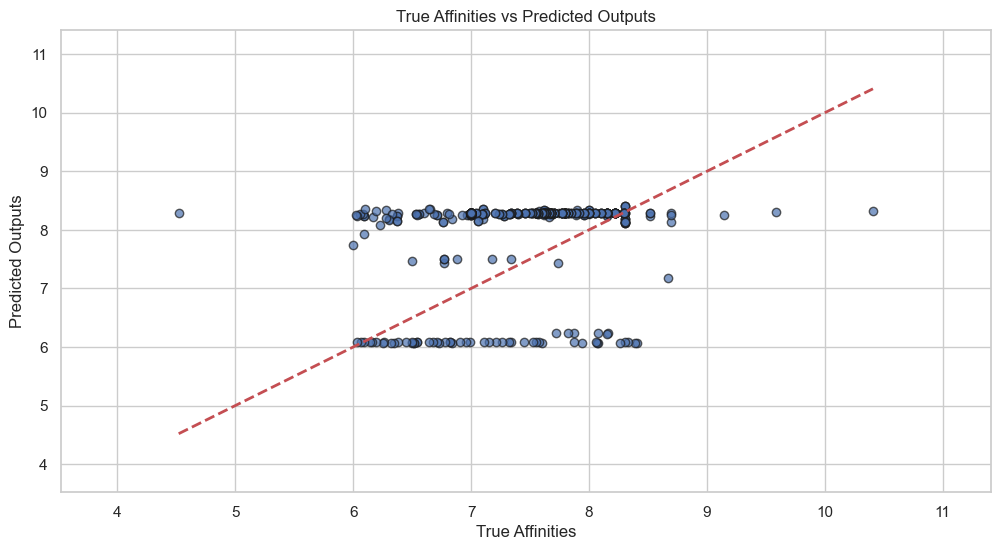

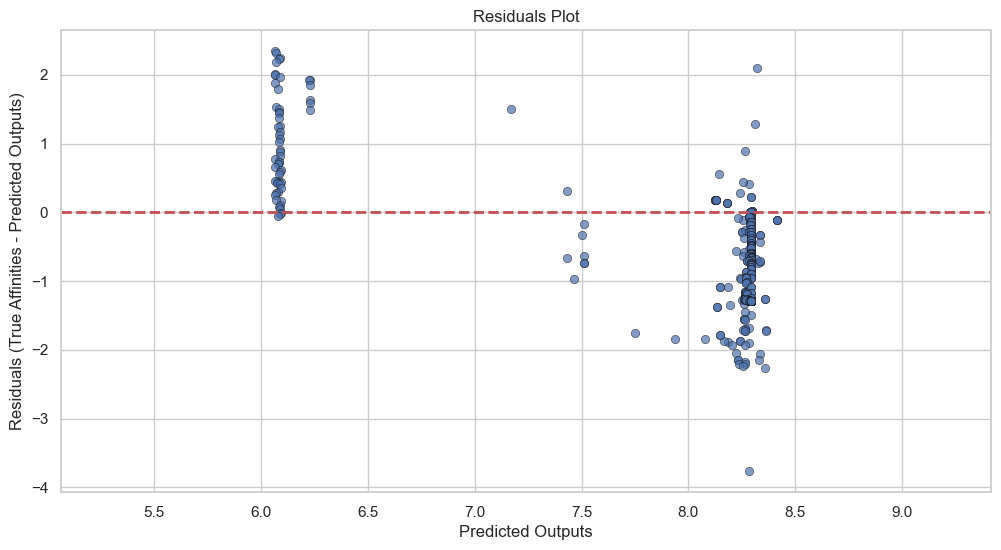

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the original data to get true affinity values
original_data = pd.read_csv('data/pharos.csv')

# Extract true affinity values from the original dataset
true_affinities = original_data['affinity'].values


# Step 4: Calculate evaluation metrics
mae = mean_absolute_error(true_affinities, outputs)
mse = mean_squared_error(true_affinities, outputs)
r2 = r2_score(true_affinities, outputs)

# Step 5: Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Data Visualization

# Ensure that outputs and true_affinities are 1D arrays
outputs = np.ravel(outputs)  # Flatten outputs if necessary
true_affinities = np.ravel(true_affinities)  # Flatten true affinities if necessary

# Calculate residuals
residuals = true_affinities - outputs

# Set the style of seaborn
sns.set(style='whitegrid')

# Scatter plot: True vs Predicted Affinities
plt.figure(figsize=(12, 6))
plt.scatter(true_affinities, outputs, alpha=0.7, edgecolors='k')
plt.plot([true_affinities.min(), true_affinities.max()], 
         [true_affinities.min(), true_affinities.max()], 
         'r--', lw=2)  # Diagonal line for reference
plt.title('True Affinities vs Predicted Outputs')
plt.xlabel('True Affinities')
plt.ylabel('Predicted Outputs')
plt.xlim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.ylim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.show()

# Residual plot: Errors
plt.figure(figsize=(12, 6))
sns.scatterplot(x=outputs, y=residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line at zero for reference
plt.title('Residuals Plot')
plt.xlabel('Predicted Outputs')
plt.ylabel('Residuals (True Affinities - Predicted Outputs)')
plt.xlim(outputs.min() - 1, outputs.max() + 1)
plt.show()


# DAVIS

Mean Absolute Error (MAE): 2.9049341806964644
Mean Squared Error (MSE): 9.003705680819813
R-squared (R²): -13.593521592995534


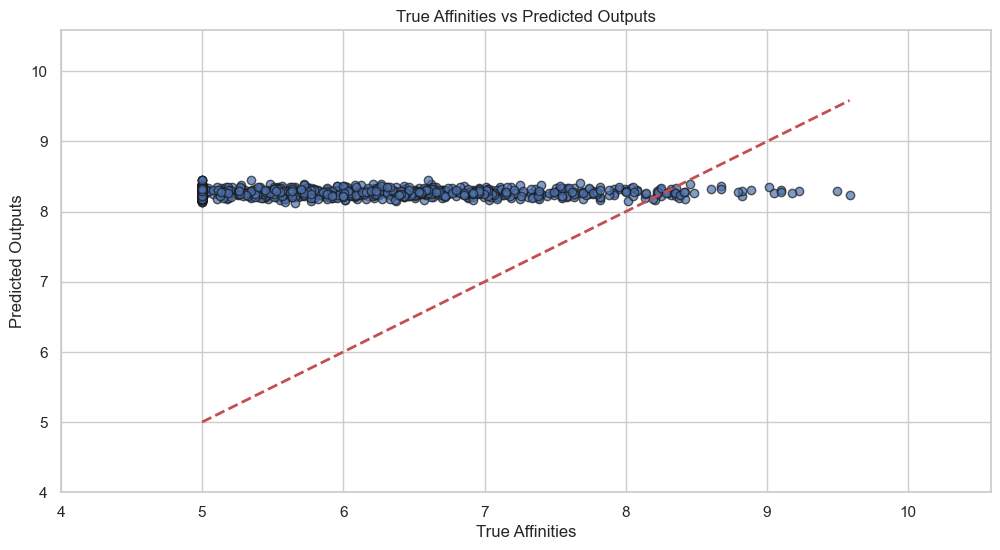

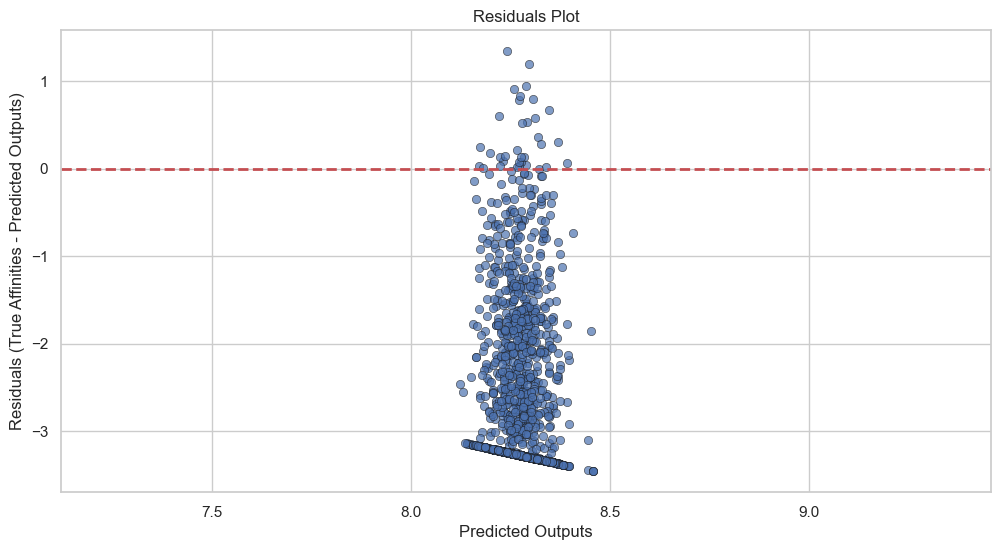

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the original data to get true affinity values
original_data = pd.read_csv('../data/davis/davis_valid.csv')

# Extract true affinity values from the original dataset
true_affinities = original_data['Y'].values


# Step 4: Calculate evaluation metrics
mae = mean_absolute_error(true_affinities, davis_valid_outputs)
mse = mean_squared_error(true_affinities, davis_valid_outputs)
r2 = r2_score(true_affinities, davis_valid_outputs)

# Step 5: Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Data Visualization

# Ensure that outputs and true_affinities are 1D arrays
davis_valid_outputs = np.ravel(davis_valid_outputs)  # Flatten outputs if necessary
true_affinities = np.ravel(true_affinities)  # Flatten true affinities if necessary

# Calculate residuals
residuals = true_affinities - davis_valid_outputs

# Set the style of seaborn
sns.set(style='whitegrid')

# Scatter plot: True vs Predicted Affinities
plt.figure(figsize=(12, 6))
plt.scatter(true_affinities, davis_valid_outputs, alpha=0.7, edgecolors='k')
plt.plot([true_affinities.min(), true_affinities.max()], 
         [true_affinities.min(), true_affinities.max()], 
         'r--', lw=2)  # Diagonal line for reference
plt.title('True Affinities vs Predicted Outputs')
plt.xlabel('True Affinities')
plt.ylabel('Predicted Outputs')
plt.xlim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.ylim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.show()

# Residual plot: Errors
plt.figure(figsize=(12, 6))
sns.scatterplot(x=davis_valid_outputs, y=residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line at zero for reference
plt.title('Residuals Plot')
plt.xlabel('Predicted Outputs')
plt.ylabel('Residuals (True Affinities - Predicted Outputs)')
plt.xlim(davis_valid_outputs.min() - 1, davis_valid_outputs.max() + 1)
plt.show()

